# Определение перспективного тарифа для телеком компании

Необходимо сделать предварительный анализ тарифов «Смарт» и «Ультра» на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: нужно изучить кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше. 
Коммерческий департамент интересует какой тариф приносит больше дене, чтобы скорректировать рекламный бюджет.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
from pandas.tseries.offsets import DateOffset

## Изучение данных из файла

In [2]:
calls = pd.read_csv('/***/***.csv')
internet = pd.read_csv('/***/***.csv')
messages  = pd.read_csv('/***/***.csv')
tariffs = pd.read_csv('/***/***.csv')
users = pd.read_csv('/***/***.csv')

Изучим данные о звонках
id — уникальный номер звонка
call_date — дата звонка
duration — длительность звонка в минутах
user_id — идентификатор пользователя, сделавшего звонок

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Пропусков нет.
В столбце duration есть записи с длительностью 0 - вероятно, неотвеченные вызовы.
Дату звонка нужно будет перевести в формат даты.

Изучим данные об использовании интернет трафика
id — уникальный номер сессии
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
session_date — дата интернет-сессии
user_id — идентификатор пользователя

In [5]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [6]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

In [7]:
internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


В таблице Internet оказался столбец "Unnamed: 0", которого не было в описании данных. Похоже на дубликат индексов.
Дату сессии нужно будет перевсти в формат даты.
Пропусков нет.

Изучим данные о сообщениях.
id — уникальный номер сообщения
message_date — дата сообщения
user_id — идентификатор пользователя, отправившего сообщение

In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [9]:
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


Дату сообщения нужно будет перевсти в формат даты.
Пропусков нет.

Изучим информацию о тарифах.
tariff_name — название тарифа
rub_monthly_fee — ежемесячная абонентская плата в рублях
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
messages_included — количество сообщений в месяц, включённых в абонентскую плату
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
rub_per_message — стоимость отправки сообщения сверх тарифного пакета
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [10]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [11]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


К тарифам вопросов нет.

Изучим информацию о пользователях.  
user_id — уникальный идентификатор пользователя  
first_name — имя пользователя  
last_name — фамилия пользователя  
age — возраст пользователя (годы)  
reg_date — дата подключения тарифа (день, месяц, год)  
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
city — город проживания пользователя  
tariff — название тарифного плана  

In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [13]:
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


В информации о пользователях churn_date и reg_date нужно будет перевести в формат даты (churn_date указана не для всех записей).

In [14]:
users['user_id'].value_counts().sort_values()

1023    1
1020    1
1019    1
1018    1
1017    1
       ..
1052    1
1053    1
1054    1
1035    1
1024    1
Name: user_id, Length: 500, dtype: int64

Каждый пользователь встречается в таблице только один раз.

In [15]:
users['city'].value_counts()

Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Иваново             1
Архангельск         1
Химки               1
Нижневартовск       1
Подольск            1
Name: city, Length: 76, dtype: int64

In [16]:
users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [17]:
users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

### Выводы
Дату звонка нужно будет перевести в формат даты.  
В таблице Internet оказался столбец "Unnamed: 0", которого не было в описании данных. Похоже на дубликат индексов.  
Дату сессии (интернет) нужно будет перевсти в формат даты.  
Дату сообщения нужно будет перевести в формат даты.  
В информации о пользователях churn_date и reg_date нужно будет перевести в формат даты (churn_date указана не для всех записей).

## Предобработка данных

Избавимся от лишней колонки в internet

In [18]:
internet = internet.drop(columns='Unnamed: 0')

Переведем даты в формат даты

In [19]:
calls['call_date'] = pd.to_datetime(calls['call_date'],
format='%Y-%m-%d')

In [20]:
internet['session_date'] = pd.to_datetime(internet['session_date'],
format='%Y-%m-%d')

In [21]:
messages['message_date'] = pd.to_datetime(messages['message_date'],
format='%Y-%m-%d')

In [22]:
users['reg_date'] = pd.to_datetime(users['reg_date'],
format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'],
format='%Y-%m-%d')

In [23]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


##  Расчеты

Звонки с нулевой длительностью удалим - на них не расходуются минуты, они не понадобятся нам, чтобы ответить на поставленные вопросы.

In [24]:
calls.drop(calls[calls.duration == 0].index, inplace=True)

In [25]:
calls = calls.reset_index(drop=True)

In [26]:
calls.head()

,id,call_date,duration,user_id
0,1000_2,2018-06-11,2.85,1000
1,1000_3,2018-09-21,13.80,1000
2,1000_4,2018-12-15,5.18,1000
3,1000_7,2018-08-22,18.31,1000
4,1000_8,2018-09-15,18.44,1000


In [27]:
len(calls)

162994

Из 202607 записей осталось 162994

Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам. Длительность звонка округлим до минут (всегда в большую сторону) и добавим в новый столбец.

In [28]:
calls['billable_duration'] = np.ceil(calls['duration'])

In [29]:
calls['month'] = calls['call_date'].values.astype('datetime64[M]')

In [30]:
calls.head()

,id,call_date,duration,user_id,billable_duration,month
0,1000_2,2018-06-11,2.85,1000,3.0,2018-06-01
1,1000_3,2018-09-21,13.80,1000,14.0,2018-09-01
2,1000_4,2018-12-15,5.18,1000,6.0,2018-12-01
3,1000_7,2018-08-22,18.31,1000,19.0,2018-08-01
4,1000_8,2018-09-15,18.44,1000,19.0,2018-09-01


In [31]:
calls_stat = calls.groupby(['user_id','month'])['billable_duration'].agg(['count', 'sum']).reset_index()
calls_stat.columns = ['user_id', 'month', 'calls_count', 'calls_sum']
calls_stat

,user_id,month,calls_count,calls_sum
0,1000,2018-05-01,17,159.0
1,1000,2018-06-01,28,172.0
2,1000,2018-07-01,41,340.0
3,1000,2018-08-01,42,408.0
4,1000,2018-09-01,46,466.0
...,...,...,...,...
3163,1498,2018-10-01,30,247.0
3164,1499,2018-09-01,8,70.0
3165,1499,2018-10-01,44,449.0
3166,1499,2018-11-01,62,612.0


Посчитаем для каждого пользователя количество отправленных сообщений по месяцам;

In [32]:
messages['month'] = messages['message_date'].values.astype('datetime64[M]')

In [33]:
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,2018-06-01
1,1000_1,2018-10-08,1000,2018-10-01
2,1000_2,2018-08-04,1000,2018-08-01
3,1000_3,2018-06-16,1000,2018-06-01
4,1000_4,2018-12-05,1000,2018-12-01


In [34]:
messages_stat = messages.groupby(['user_id','month'])['id'].agg('count').reset_index()
messages_stat.columns = ['user_id','month','messages_count']
messages_stat.head(10)

,user_id,month,messages_count
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57
5,1000,2018-10-01,73
6,1000,2018-11-01,58
7,1000,2018-12-01,70
8,1002,2018-06-01,4
9,1002,2018-07-01,11


Посчитаем для каждого пользователя объем израсходованного интернет-трафика по месяцам.

In [35]:
internet['month'] = internet['session_date'].values.astype('datetime64[M]')

In [36]:
internet[internet['mb_used']==0].tail()

,id,mb_used,session_date,user_id,month
149380,1499_141,0.0,2018-12-11,1499,2018-12-01
149381,1499_142,0.0,2018-11-01,1499,2018-11-01
149383,1499_144,0.0,2018-11-27,1499,2018-11-01
149386,1499_147,0.0,2018-10-21,1499,2018-10-01
149393,1499_154,0.0,2018-10-27,1499,2018-10-01


Удалим строки с нулевым трафиком

In [37]:
internet.drop(internet[internet['mb_used'] == 0].index, inplace=True)

In [38]:
internet[internet['mb_used']==0]

,id,mb_used,session_date,user_id,month


In [39]:
internet['billable_mb'] = np.ceil(internet['mb_used'])

In [40]:
internet.head()

,id,mb_used,session_date,user_id,month,billable_mb
0,1000_0,112.95,2018-11-25,1000,2018-11-01,113.0
1,1000_1,1052.81,2018-09-07,1000,2018-09-01,1053.0
2,1000_2,1197.26,2018-06-25,1000,2018-06-01,1198.0
3,1000_3,550.27,2018-08-22,1000,2018-08-01,551.0
4,1000_4,302.56,2018-09-24,1000,2018-09-01,303.0


In [41]:
internet_stat=internet.groupby(['user_id','month'])['billable_mb'].agg('sum').reset_index()

In [42]:
internet_stat.tail(10)

,user_id,month,billable_mb
3191,1497,2018-11-01,14174.0
3192,1497,2018-12-01,19940.0
3193,1498,2018-07-01,7486.0
3194,1498,2018-08-01,24270.0
3195,1498,2018-09-01,22166.0
3196,1498,2018-10-01,20604.0
3197,1499,2018-09-01,1848.0
3198,1499,2018-10-01,17809.0
3199,1499,2018-11-01,17984.0
3200,1499,2018-12-01,13077.0


Посчитаем помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

In [43]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [44]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [45]:
df = users.join(tariffs.set_index('tariff_name'), on='tariff')
df.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15360,500,550,200,3,3
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1000,30720,3000,1950,150,1,1
5,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15360,500,550,200,3,3
6,1006,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart,50,15360,500,550,200,3,3
7,1007,65,NaT,Москва,Юна,Березина,2018-04-19,smart,50,15360,500,550,200,3,3
8,1008,63,NaT,Челябинск,Рустэм,Пономарёв,2018-12-19,smart,50,15360,500,550,200,3,3
9,1009,24,NaT,Пермь,Василиса,Блинова,2018-03-22,smart,50,15360,500,550,200,3,3


Добавим в таблицу информацию о звонках.

Посмотрим за какой период у нас есть данные.

In [46]:
min_month = df['reg_date'].values.astype('datetime64[M]').min()

In [47]:
max_month = calls['call_date'].values.astype('datetime64[M]').max()

In [48]:
min_month

numpy.datetime64('2018-01')

In [49]:
max_month

numpy.datetime64('2018-12')

In [50]:
pd.date_range(min_month,max_month,freq='MS')

DatetimeIndex(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [51]:
dr = pd.DataFrame(pd.date_range(min_month,max_month,freq='MS'))

In [52]:
dr.columns = ['month']
dr

,month
0,2018-01-01
1,2018-02-01
2,2018-03-01
3,2018-04-01
4,2018-05-01
5,2018-06-01
6,2018-07-01
7,2018-08-01
8,2018-09-01
9,2018-10-01


У нас есть данные за 12 месяцев 2018го года.

Для каждого пользователя добавим строку на каждый месяц.

In [53]:
dr['key'] = 1
df['key'] = 1

In [54]:
df = dr.merge(df,on='key')

In [55]:
df.head(10)

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,2018-01-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,2018-01-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3
2,2018-01-01,1,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15360,500,550,200,3,3
3,2018-01-01,1,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1
4,2018-01-01,1,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1000,30720,3000,1950,150,1,1
5,2018-01-01,1,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15360,500,550,200,3,3
6,2018-01-01,1,1006,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart,50,15360,500,550,200,3,3
7,2018-01-01,1,1007,65,NaT,Москва,Юна,Березина,2018-04-19,smart,50,15360,500,550,200,3,3
8,2018-01-01,1,1008,63,NaT,Челябинск,Рустэм,Пономарёв,2018-12-19,smart,50,15360,500,550,200,3,3
9,2018-01-01,1,1009,24,NaT,Пермь,Василиса,Блинова,2018-03-22,smart,50,15360,500,550,200,3,3


In [56]:
df.query('user_id==1001')

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
1,2018-01-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3
501,2018-02-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3
1001,2018-03-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3
1501,2018-04-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3
2001,2018-05-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3
2501,2018-06-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3
3001,2018-07-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3
3501,2018-08-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3
4001,2018-09-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3
4501,2018-10-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3


In [57]:
len(users)*len(dr)

6000

In [58]:
len(df)

6000

Для каждого пользователя у нас теперь есть строка на каждый месяц, по которому могут быть данные.

Уберём лишние строки: до месяца регистрации и после месяца отключения.
Сначала добавим в таблицу столбцы с месяцем регистрации и месяцем отключения.

In [59]:
df['reg_month'] = df['reg_date'].values.astype('datetime64[M]')

In [60]:
df['term_month'] = df['churn_date'].values.astype('datetime64[M]')

In [61]:
df.head(10)

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,reg_month,term_month
0,2018-01-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,2018-05-01,NaT
1,2018-01-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,50,15360,500,550,200,3,3,2018-11-01,NaT
2,2018-01-01,1,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,50,15360,500,550,200,3,3,2018-06-01,NaT
3,2018-01-01,1,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1,2018-08-01,NaT
4,2018-01-01,1,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1000,30720,3000,1950,150,1,1,2018-05-01,NaT
5,2018-01-01,1,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,50,15360,500,550,200,3,3,2018-01-01,NaT
6,2018-01-01,1,1006,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart,50,15360,500,550,200,3,3,2018-02-01,NaT
7,2018-01-01,1,1007,65,NaT,Москва,Юна,Березина,2018-04-19,smart,50,15360,500,550,200,3,3,2018-04-01,NaT
8,2018-01-01,1,1008,63,NaT,Челябинск,Рустэм,Пономарёв,2018-12-19,smart,50,15360,500,550,200,3,3,2018-12-01,NaT
9,2018-01-01,1,1009,24,NaT,Пермь,Василиса,Блинова,2018-03-22,smart,50,15360,500,550,200,3,3,2018-03-01,NaT


Удалим строки с месяцами, в которых пользователи не были подключены

In [62]:
len(df[(df['month']>=df['reg_month']) & ~(df['month']>df['term_month'])])

3216

In [63]:
df = df[(df['month']>=df['reg_month']) & ~(df['month']>df['term_month'])]

In [64]:
df.query('user_id == 1498')

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,reg_month,term_month
3498,2018-07-01,1,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,50,15360,500,550,200,3,3,2018-07-01,2018-10-01
3998,2018-08-01,1,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,50,15360,500,550,200,3,3,2018-07-01,2018-10-01
4498,2018-09-01,1,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,50,15360,500,550,200,3,3,2018-07-01,2018-10-01
4998,2018-10-01,1,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,50,15360,500,550,200,3,3,2018-07-01,2018-10-01


Соберем в одну таблицу все данные об использовании сервиса.

In [65]:
stats = calls_stat.merge(messages_stat, how='outer', on=['user_id','month'])

In [66]:
stats = stats.merge(internet_stat, how='outer', on=['user_id','month'])

In [67]:
stats.head(15)

,user_id,month,calls_count,calls_sum,messages_count,billable_mb
0,1000,2018-05-01,17.0,159.0,22.0,2256.0
1,1000,2018-06-01,28.0,172.0,60.0,23257.0
2,1000,2018-07-01,41.0,340.0,75.0,14016.0
3,1000,2018-08-01,42.0,408.0,81.0,14070.0
4,1000,2018-09-01,46.0,466.0,57.0,14581.0
5,1000,2018-10-01,44.0,350.0,73.0,14717.0
6,1000,2018-11-01,37.0,338.0,58.0,14768.0
7,1000,2018-12-01,38.0,333.0,70.0,9827.0
8,1001,2018-11-01,45.0,430.0,NaN,18452.0
9,1001,2018-12-01,47.0,414.0,NaN,14053.0


In [68]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id           3214 non-null int64
month             3214 non-null datetime64[ns]
calls_count       3168 non-null float64
calls_sum         3168 non-null float64
messages_count    2717 non-null float64
billable_mb       3201 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 175.8 KB


Объединим таблицу с пользователями и тарифами с таблицей с данными об использовании сервиса. 

In [69]:
report = df.merge(stats,how='left',on=['user_id','month'])

In [70]:
report.head(10)

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,...,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,reg_month,term_month,calls_count,calls_sum,messages_count,billable_mb
0,2018-01-01,1,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,...,550,200,3,3,2018-01-01,NaT,11.0,95.0,7.0,2730.0
1,2018-01-01,1,1032,31,NaT,Ульяновск,Инна,Игнатьева,2018-01-04,smart,...,550,200,3,3,2018-01-01,NaT,44.0,380.0,38.0,24147.0
2,2018-01-01,1,1045,48,NaT,Улан-Удэ,Джемма,Карасева,2018-01-30,smart,...,550,200,3,3,2018-01-01,NaT,1.0,9.0,5.0,2348.0
3,2018-01-01,1,1055,39,NaT,Казань,Луиза,Березина,2018-01-02,smart,...,550,200,3,3,2018-01-01,NaT,47.0,551.0,30.0,17111.0
4,2018-01-01,1,1071,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,...,550,200,3,3,2018-01-01,2018-08-01,18.0,194.0,16.0,15622.0
5,2018-01-01,1,1113,52,NaT,Чита,Харитон,Булгаков,2018-01-24,smart,...,550,200,3,3,2018-01-01,NaT,13.0,110.0,14.0,767.0
6,2018-01-01,1,1120,25,NaT,Краснодар,Агнесса,Абдулина,2018-01-24,ultra,...,1950,150,1,1,2018-01-01,NaT,4.0,55.0,NaN,657.0
7,2018-01-01,1,1126,71,NaT,Санкт-Петербург,Яна,Арсенкова,2018-01-19,ultra,...,1950,150,1,1,2018-01-01,NaT,28.0,272.0,4.0,16377.0
8,2018-01-01,1,1134,65,NaT,Красноярск,Марьяна,Авросимова,2018-01-16,smart,...,550,200,3,3,2018-01-01,NaT,33.0,332.0,32.0,10215.0
9,2018-01-01,1,1135,64,NaT,Архангельск,Милена,Воронина,2018-01-29,smart,...,550,200,3,3,2018-01-01,NaT,9.0,90.0,1.0,1601.0


In [71]:
report[report['user_id']==1000]

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,...,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,reg_month,term_month,calls_count,calls_sum,messages_count,billable_mb
406,2018-05-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,...,1950,150,1,1,2018-05-01,NaT,17.0,159.0,22.0,2256.0
614,2018-06-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,...,1950,150,1,1,2018-05-01,NaT,28.0,172.0,60.0,23257.0
862,2018-07-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,...,1950,150,1,1,2018-05-01,NaT,41.0,340.0,75.0,14016.0
1154,2018-08-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,...,1950,150,1,1,2018-05-01,NaT,42.0,408.0,81.0,14070.0
1496,2018-09-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,...,1950,150,1,1,2018-05-01,NaT,46.0,466.0,57.0,14581.0
1871,2018-10-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,...,1950,150,1,1,2018-05-01,NaT,44.0,350.0,73.0,14717.0
2288,2018-11-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,...,1950,150,1,1,2018-05-01,NaT,37.0,338.0,58.0,14768.0
2738,2018-12-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,...,1950,150,1,1,2018-05-01,NaT,38.0,333.0,70.0,9827.0


Проверим, что никакие данные не потерялись при объединении таблиц

In [72]:
report['calls_sum'].sum()

1450301.0

In [73]:
calls_stat['calls_sum'].sum()

1450301.0

In [74]:
report['messages_count'].sum()

123036.0

In [75]:
messages_stat['messages_count'].sum()

123036

In [76]:
report['billable_mb'].sum()

55369459.0

In [77]:
internet_stat['billable_mb'].sum()

55369459.0

In [78]:
report.isna().mean()

month                    0.000000
key                      0.000000
user_id                  0.000000
age                      0.000000
churn_date               0.941231
city                     0.000000
first_name               0.000000
last_name                0.000000
reg_date                 0.000000
tariff                   0.000000
messages_included        0.000000
mb_per_month_included    0.000000
minutes_included         0.000000
rub_monthly_fee          0.000000
rub_per_gb               0.000000
rub_per_message          0.000000
rub_per_minute           0.000000
reg_month                0.000000
term_month               0.941231
calls_count              0.014925
calls_sum                0.014925
messages_count           0.155162
billable_mb              0.004664
dtype: float64

В некоторых месяцах некоторые клиенты не звонили, не писали сообщения, или не использовали интернет. Заменим такие пропуски на нули, чтобы можно было проводить расчеты.

In [79]:
report['calls_count'] = report['calls_sum'].fillna(0)
report['calls_sum'] = report['calls_sum'].fillna(0)
report['messages_count'] = report['messages_count'].fillna(0)
report['billable_mb'] = report['billable_mb'].fillna(0)

In [80]:
report.isna().mean()

month                    0.000000
key                      0.000000
user_id                  0.000000
age                      0.000000
churn_date               0.941231
city                     0.000000
first_name               0.000000
last_name                0.000000
reg_date                 0.000000
tariff                   0.000000
messages_included        0.000000
mb_per_month_included    0.000000
minutes_included         0.000000
rub_monthly_fee          0.000000
rub_per_gb               0.000000
rub_per_message          0.000000
rub_per_minute           0.000000
reg_month                0.000000
term_month               0.941231
calls_count              0.000000
calls_sum                0.000000
messages_count           0.000000
billable_mb              0.000000
dtype: float64

Пропуски заполнены. Рассчитаем выручку.

In [81]:
report['revenue'] = report['rub_monthly_fee'] + (report['messages_count'] - report['messages_included']).clip(0)*report['rub_per_message'] + (report['billable_mb'] - report['mb_per_month_included']).clip(0)*report['rub_per_gb']/1024 + (report['calls_sum'] - report['minutes_included']).clip(0)*report['rub_per_minute']

In [82]:
report.head(10)

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,...,rub_per_gb,rub_per_message,rub_per_minute,reg_month,term_month,calls_count,calls_sum,messages_count,billable_mb,revenue
0,2018-01-01,1,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,...,200,3,3,2018-01-01,NaT,95.0,95.0,7.0,2730.0,550.000000
1,2018-01-01,1,1032,31,NaT,Ульяновск,Инна,Игнатьева,2018-01-04,smart,...,200,3,3,2018-01-01,NaT,380.0,380.0,38.0,24147.0,2266.210938
2,2018-01-01,1,1045,48,NaT,Улан-Удэ,Джемма,Карасева,2018-01-30,smart,...,200,3,3,2018-01-01,NaT,9.0,9.0,5.0,2348.0,550.000000
3,2018-01-01,1,1055,39,NaT,Казань,Луиза,Березина,2018-01-02,smart,...,200,3,3,2018-01-01,NaT,551.0,551.0,30.0,17111.0,1044.992188
4,2018-01-01,1,1071,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,...,200,3,3,2018-01-01,2018-08-01,194.0,194.0,16.0,15622.0,601.171875
5,2018-01-01,1,1113,52,NaT,Чита,Харитон,Булгаков,2018-01-24,smart,...,200,3,3,2018-01-01,NaT,110.0,110.0,14.0,767.0,550.000000
6,2018-01-01,1,1120,25,NaT,Краснодар,Агнесса,Абдулина,2018-01-24,ultra,...,150,1,1,2018-01-01,NaT,55.0,55.0,0.0,657.0,1950.000000
7,2018-01-01,1,1126,71,NaT,Санкт-Петербург,Яна,Арсенкова,2018-01-19,ultra,...,150,1,1,2018-01-01,NaT,272.0,272.0,4.0,16377.0,1950.000000
8,2018-01-01,1,1134,65,NaT,Красноярск,Марьяна,Авросимова,2018-01-16,smart,...,200,3,3,2018-01-01,NaT,332.0,332.0,32.0,10215.0,550.000000
9,2018-01-01,1,1135,64,NaT,Архангельск,Милена,Воронина,2018-01-29,smart,...,200,3,3,2018-01-01,NaT,90.0,90.0,1.0,1601.0,550.000000


### Выводы
Мы рассчитали следующие параметры:
* количество сделанных звонков и израсходованных минут разговора по месяцам (минуты округлили в большую сторону);
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам (с округлением до целого мегабайта в большую сторону);
* помесячную выручку с каждого пользователя

# Анализ данных

Проанализируем сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц

In [83]:
report.groupby(['tariff'])['calls_sum','messages_count', 'billable_mb'].mean()

,calls_sum,messages_count,billable_mb
tariff,,,
smart,417.747534,33.369058,16221.910762
ultra,526.089249,49.313387,19467.137931


Количество месяцев у нас небольшое, для многих пользователей есть месяца где они пользовались услугой не полный месяц, что, вероятно, влияет на расчеты. Попробуем исключить неполные месяца.

In [84]:
report_full_months = report[(((report['month']==report['reg_month'])& (pd.DatetimeIndex(report['reg_date']).is_month_start == True)) |
       (report['month']>report['reg_month']))
       & ~(((report['month']==(report['term_month']))& (pd.DatetimeIndex(report['churn_date']).is_month_end == False)) |
       (report['month']>report['term_month']))
       ]

In [85]:
len(report_full_months)

2699

Осталось 2699 строк. Проверим на пользователе, у которого есть дата отключения.

In [86]:
report_full_months.query('user_id == 1498')

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,...,rub_per_gb,rub_per_message,rub_per_minute,reg_month,term_month,calls_count,calls_sum,messages_count,billable_mb,revenue
1495,2018-08-01,1,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,...,200,3,3,2018-07-01,2018-10-01,400.0,400.0,62.0,24270.0,2326.234375
1869,2018-09-01,1,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,...,200,3,3,2018-07-01,2018-10-01,471.0,471.0,44.0,22166.0,1879.296875


Пользователь 1498 подключился 19го числа, а отключился тоже 19го. Теперь у нас для него в таблице нет строки с месяцем регистрации и месяцем отлючения.

Посчитаем средние значения еще раз.

In [87]:
report_full_months.groupby(['tariff'])['calls_sum','messages_count', 'billable_mb'].mean().round(0).reset_index()

,tariff,calls_sum,messages_count,billable_mb
0,smart,453.0,36.0,17557.0
1,ultra,574.0,53.0,21154.0


Ожидаемо, средние значения рассчитанные по полным месяцам использования, выше. 

В среднем за месяц пользователи тарифа Smart используют:
+ 453 минуты разговоров
+ 36 сообщений
+ 17557 мб трафика
Пользователи тарифа Ultra:
+ 574 минуты разговоров
+ 53 сообщения
+ 21154 мб трафика

Посчитаем дисперсию и стандартное отклонение для каждого тарифа.

In [88]:
variance_estimate = np.var(report[report['tariff']=='smart']['calls_sum'], ddof=1)
print(variance_estimate)

36281.393836444586


In [89]:
standard_deviation = np.std(report[report['tariff']=='smart']['calls_sum'], ddof=1)
print(standard_deviation) 

190.4767540579285


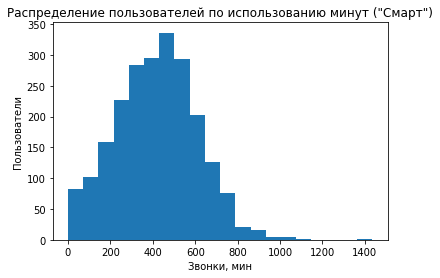

In [90]:
report[report['tariff']=='smart']['calls_sum'].plot(kind = 'hist', bins=20, title = 'Распределение пользователей по использованию минут ("Смарт")')
plt.xlabel('Звонки, мин')
plt.ylabel("Пользователи")
plt.show()

In [91]:
report[report['tariff']=='smart']['calls_sum'].describe()

count    2230.000000
mean      417.747534
std       190.476754
min         0.000000
25%       282.000000
50%       421.500000
75%       545.000000
max      1435.000000
Name: calls_sum, dtype: float64

Гистограмма скошенна влево, но медиана и среднее практически равны.

In [92]:
variance_estimate = np.var(report[report['tariff']=='smart']['messages_count'], ddof=1)
print(variance_estimate)

796.9552557301129


In [93]:
np.std(report[report['tariff']=='smart']['messages_count'], ddof=1)

28.230395954185852

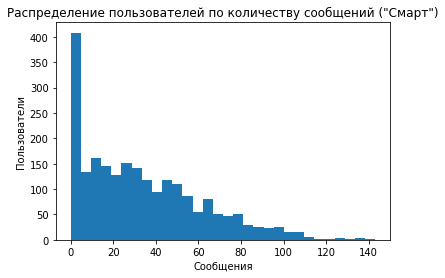

In [94]:
report[report['tariff']=='smart']['messages_count'].plot(kind = 'hist', bins=30, title = 'Распределение пользователей по количеству сообщений ("Смарт")')
plt.xlabel('Сообщения')
plt.ylabel("Пользователи")
plt.show()

In [95]:
report[report['tariff']=='smart']['messages_count'].describe()

count    2230.000000
mean       33.369058
std        28.230396
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages_count, dtype: float64

Явный пик около нуля свидетельствует о том, что многие люди практически не используют сообщения. Возможно, они предпочитают интернет-мессенджеры.

In [96]:
variance_estimate = np.var(report[report['tariff']=='smart']['billable_mb'], ddof=1)
print(variance_estimate)

34648523.30069166


In [97]:
np.std(report[report['tariff']=='smart']['billable_mb'], ddof=1)

5886.299627158955

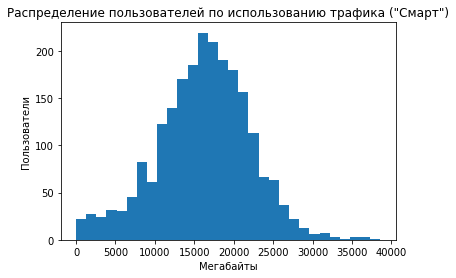

In [98]:
report[report['tariff']=='smart']['billable_mb'].plot(kind = 'hist', bins=30, title = 'Распределение пользователей по использованию трафика ("Смарт")')
plt.xlabel('Мегабайты')
plt.ylabel("Пользователи")
plt.show()

In [99]:
report[report['tariff']=='smart']['billable_mb'].describe()

count     2230.000000
mean     16221.910762
std       5886.299627
min          0.000000
25%      12645.250000
50%      16529.000000
75%      20068.000000
max      38610.000000
Name: billable_mb, dtype: float64

Распределение близко к нормальному. Среднее и медиана почти не отличаются.

Посмотрим на тариф Ultra

In [100]:
variance_estimate = np.var(report[report['tariff']=='ultra']['calls_sum'], ddof=1)
print(variance_estimate)

101052.49354928388


In [101]:
standard_deviation = np.std(report[report['tariff']=='ultra']['calls_sum'], ddof=1)
print(standard_deviation) 

317.8875485911392


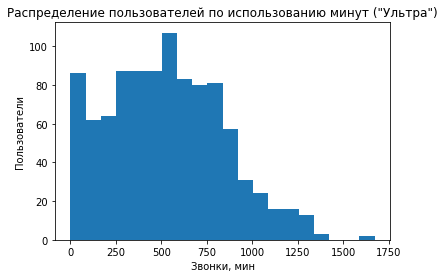

In [102]:
report[report['tariff']=='ultra']['calls_sum'].plot(kind = 'hist', bins=20, title = 'Распределение пользователей по использованию минут ("Ультра")')
plt.xlabel('Звонки, мин')
plt.ylabel("Пользователи")
plt.show()

In [103]:
report[report['tariff']=='ultra']['calls_sum'].describe()

count     986.000000
mean      526.089249
std       317.887549
min         0.000000
25%       282.500000
50%       518.000000
75%       751.750000
max      1673.000000
Name: calls_sum, dtype: float64

Гистограмма опять же скошенна влево, но медиана и среднее практически равны.

In [104]:
variance_estimate = np.var(report[report['tariff']=='ultra']['messages_count'], ddof=1)
print(variance_estimate)

2285.417424655842


In [105]:
np.std(report[report['tariff']=='ultra']['messages_count'], ddof=1)

47.80603962530092

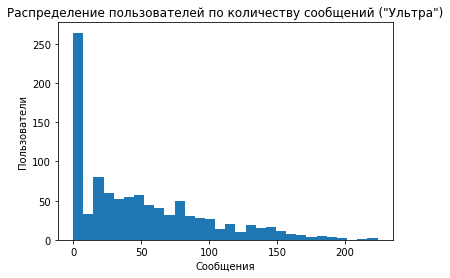

In [106]:
report[report['tariff']=='ultra']['messages_count'].plot(kind = 'hist', bins=30, title = 'Распределение пользователей по количеству сообщений ("Ультра")')
plt.xlabel('Сообщения')
plt.ylabel("Пользователи")
plt.show()

In [107]:
report[report['tariff']=='ultra']['messages_count'].describe()

count    986.000000
mean      49.313387
std       47.806040
min        0.000000
25%        6.000000
50%       38.000000
75%       78.750000
max      224.000000
Name: messages_count, dtype: float64

Пик около нуля сообщений еще более явный,чем для тарифа Smart. В целом разброс значений относительно среднего более значительный, чем на тарифе Smart.

In [108]:
variance_estimate = np.var(report[report['tariff']=='ultra']['billable_mb'], ddof=1)
print(variance_estimate)

102217264.27537197


In [109]:
np.std(report[report['tariff']=='ultra']['billable_mb'], ddof=1)

10110.255401095066

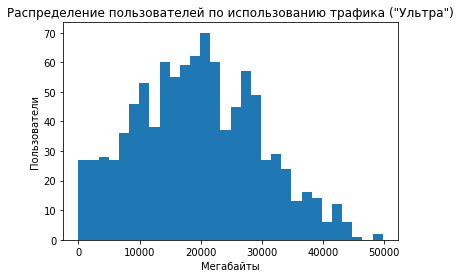

In [110]:
report[report['tariff']=='ultra']['billable_mb'].plot(kind = 'hist', bins=30, title = 'Распределение пользователей по использованию трафика ("Ультра")')
plt.xlabel('Мегабайты')
plt.ylabel("Пользователи")
plt.show()

In [111]:
report[report['tariff']=='ultra']['billable_mb'].describe()

count      986.000000
mean     19467.137931
std      10110.255401
min          0.000000
25%      11761.000000
50%      19320.000000
75%      26860.250000
max      49789.000000
Name: billable_mb, dtype: float64

Для использованного трафика также характерен больший разброс, чем в случае с тарифом Smart.

## Выводы
В среднем за месяц пользователи тарифа Smart используют:
+ 453 минуты разговоров
+ 36 сообщений
+ 17557 мб трафика
Пользователи тарифа Ultra:
+ 574 минуты разговоров
+ 53 сообщения
+ 21154 мб трафика

Ниже в таблице стастические данные по обоим тарифам.

In [112]:
report.pivot_table(index='tariff', values=['calls_sum', 'messages_count','billable_mb'],
                  aggfunc=['mean', 'std', 'var'])

mean                                      std              \
         billable_mb   calls_sum messages_count   billable_mb   calls_sum   
tariff                                                                      
smart   16221.910762  417.747534      33.369058   5886.299627  190.476754   
ultra   19467.137931  526.089249      49.313387  10110.255401  317.887549   

                                var                                
       messages_count   billable_mb      calls_sum messages_count  
tariff                                                             
smart       28.230396  3.464852e+07   36281.393836     796.955256  
ultra       47.806040  1.022173e+08  101052.493549    2285.417425

## Проверяем гипотезы

Проверим гипотезу "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается"

Для начала посмотрим на средние значения выручки по тарифам.

In [113]:
report.groupby('tariff')['revenue'].mean()

tariff
smart    1233.043032
ultra    2060.417872
Name: revenue, dtype: float64

Нулевую гипотезу сформулируем так: средняя выручка пользователей тарифов «Ультра» и «Смарт» равны.
Альтернативная гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны.

In [114]:
smart_revenue = report[report['tariff']== 'smart']['revenue']

In [115]:
ultra_revenue = report[report['tariff']== 'ultra']['revenue']

In [116]:
alpha = 0.05

results = st.ttest_ind(smart_revenue, ultra_revenue)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 6.129437607153987e-191
Отвергаем нулевую гипотезу


P-value оказался меньше критического уровня статистической значимости.
Средняя выручка по пользователям разных тарифов различается, и судя по всему это различие не случайно. Выручка от тарифа Ultra значительно привышает выручку от тарифа Smart.

Проверим гипотезу "средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов"

Посмотрим на средние значения

In [117]:
report.query('city == "Москва"')['revenue'].mean()

1507.276761968085

In [118]:
report.query('city != "Москва"')['revenue'].mean()

1481.8855588711613

Нулевую гипотезу сформулируем так: средняя выручка пользователей из Москвы и пользователей из других регионов равны.
Альтернативная гипотеза: средняя выручка пользователей из Москвы и пользователей из других регионов не равны.

In [119]:
revenue_moscow = report.query('city == "Москва"')['revenue']
revenue_others = report.query('city != "Москва"')['revenue']

In [120]:
alpha = 0.05

results = st.ttest_ind(revenue_moscow, revenue_others)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.4712668200760739
Не получилось отвергнуть нулевую гипотезу


Средние значения отличаются не сильно, и действительно, с вероятностью в 47% они могли бы оказаться одинаковыми. Значит, пользоватеди из разных регионов приносят оператору одинаковую выручку.

In [121]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Выводы
Средняя выручка по пользователям разных тарифов различается, и судя по всему это различие не случайно. Выручка от тарифа Ultra значительно привышает выручку от тарифа Smart.  
Средние значения выручки по Москве и по остальным регионам отличаются не сильно, и действительно, с вероятностью в 47% они могли бы оказаться одинаковыми. Значит, пользователи из разных регионов приносят оператору одинаковую выручку.

## Общий вывод
Провели предобработку данных:
* Дату звонка перевели в формат даты.
* В таблице Internet удалили столбец "Unnamed: 0", которого не было в описании данных. Похоже на дубликат индексов.
* Дату сессии (интернет) перевели в формат даты.
* Дату сообщения перевели в формат даты.
* В информации о пользователях churn_date и reg_date перевели в формат даты.

Мы рассчитали следующие параметры:
* количество сделанных звонков и израсходованных минут разговора по месяцам (минуты округлили в большую сторону).  Звонки с нулевой длительностью удалили - на них не расходуются минуты, они не нужны нам, чтобы ответить на поставленные вопросы.;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам (с округлением до целого мегабайта в большую сторону);
* помесячную выручку с каждого пользователя

В среднем за месяц пользователи тарифа Smart используют:
* 453 минуты разговоров
* 36 сообщений
* 17557 мб трафика 

Пользователи тарифа Ultra:
* 574 минуты разговоров
* 53 сообщения
* 21154 мб трафика

Можно также отметить, что значительное количество пользователей обоих тарифных планов вовсе не ипользует сообщения.

Средняя выручка по пользователям разных тарифов различается, и судя по всему это различие не случайно. Выручка от тарифа Ultra значительно привышает выручку от тарифа Smart. 
Средние значения выручки по Москве и по остальным регионам отличаются не сильно, и действительно, с вероятностью в 47% они могли бы оказаться одинаковыми. Значит, пользователи из разных регионов приносят оператору одинаковую выручку.
Тариф Ультра приносит больше денег, можно рекомендовать коммерческому департаменту уделить ему больше внимания.